In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
import xgboost as xgb 
import matplotlib.pyplot as plt 
import shap 

In [2]:
# Lets open the dataframe again
df = pd.read_csv(r"C:\Users\chech\OneDrive\Documentos\StudyNights\test-rappi-DS\assets\house_sales.csv")
df.head()

,price,num_bed,num_bath,size_house,size_lot,num_floors,is_waterfront,condition,size_basement,year_built,renovation_date,zip,latitude,longitude,avg_size_neighbor_houses,avg_size_neighbor_lot
0,221900,3,1.00,1180,5650,1.0,0,3,0,1955,0,98178,47.511234,-122.256775,1340,5650
1,538000,3,2.25,2570,7242,2.0,0,3,400,1951,1991,98125,47.721023,-122.318862,1690,7639
2,180000,2,1.00,770,10000,1.0,0,3,0,1933,0,98028,47.737927,-122.233196,2720,8062
3,604000,4,3.00,1960,5000,1.0,0,5,910,1965,0,98136,47.520820,-122.393185,1360,5000
4,510000,3,2.00,1680,8080,1.0,0,3,0,1987,0,98074,47.616812,-122.044901,1800,7503


In [3]:
target = df.price
#df_features = df.drop(['price', 'num_bath'], axis =1)
df_features = df.drop(['price'], axis =1)

In [6]:
params = {
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'reg:linear'
}
num_boost_round = 999

In [7]:
#X, y = scaled_df.values , target.values
X, y = df_features.values , target.values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.15, random_state=42)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)
print("Best RMSE: {} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

[00:07:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-rmse:460004.23922
[1]	Test-rmse:341925.96749
[2]	Test-rmse:264065.12042
[3]	Test-rmse:214811.43082
[4]	Test-rmse:183090.42682
[5]	Test-rmse:163148.13128
[6]	Test-rmse:151718.46144
[7]	Test-rmse:145276.65850
[8]	Test-rmse:140529.94137
[9]	Test-rmse:138368.20921
[10]	Test-rmse:137118.57354
[11]	Test-rmse:135178.99760
[12]	Test-rmse:133642.86131
[13]	Test-rmse:132098.61828
[14]	Test-rmse:131408.51324
[15]	Test-rmse:131446.92765
[16]	Test-rmse:130391.81807
[17]	Test-rmse:129797.08481
[18]	Test-rmse:129574.43847
[19]	Test-rmse:129286.21782
[20]	Test-rmse:128440.14572
[21]	Test-rmse:128226.48612
[22]	Test-rmse:128026.74138
[23]	Test-rmse:127784.25003
[24]	Test-rmse:127765.69077
[25]	Test-rmse:127209.10024
[26]	Test-rmse:126977.12941
[27]	Test-rmse:126502.18919
[28]	Test-rmse:126365.23628
[29]	Test-rmse:125764

In [8]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)

[00:08:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:08:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:08:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:08:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:08:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [9]:
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,482263.187979,2874.907665,486248.400250,15382.483590
1,358870.962369,2361.760178,366429.042621,14767.948471
2,274890.626572,1638.310443,285291.552776,14244.615883
3,218040.930243,1406.484005,232871.710010,14448.351455
4,180136.537724,691.288353,199113.476260,12405.994841
...,...,...,...,...
98,58700.310902,858.491526,134535.316674,4720.433576
99,58419.867206,770.172944,134536.382012,4723.409361
100,58209.070439,769.333697,134544.022570,4729.999322
101,57906.532068,858.247881,134541.545121,4737.343879


In [10]:
cv_results['test-rmse-mean'].min()

134469.75571097055

In [11]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [12]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=9, min_child_weight=5
[00:08:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:08:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:08:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:08:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:08:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 75346.47311563298 for 44 rounds
CV with max_depth=9, min_child_weight=

In [13]:
params['max_depth'] = 9
params['min_child_weight'] = 7

In [14]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [15]:
min_mae = float("Inf")
best_params = None# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
[00:10:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:10:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:10:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:10:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:10:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 74838.66938376913 for 59 rounds
CV with subsample=1.0, colsample=0.9
[00:

In [16]:
params['subsample'] = 1
params['colsample_bytree'] = 1.

In [17]:
%time
# This can take some time…
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))    # We update our parameters
    params['eta'] = eta    # Run and time CV
    %time 
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics=['mae'],
            early_stopping_rounds=10
    )    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

Wall time: 0 ns
CV with eta=0.3
Wall time: 0 ns
[00:13:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 74838.66938376913 for 59 rounds

CV with eta=0.2
Wall time: 0 

In [18]:
params['eta'] = .05

In [19]:
params

{'max_depth': 9,
 'min_child_weight': 7,
 'eta': 0.05,
 'subsample': 1,
 'colsample_bytree': 1.0,
 'objective': 'reg:linear'}

In [20]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)
print("Best RMSE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

[00:16:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-rmse:603216.41458
[1]	Test-rmse:575511.45953
[2]	Test-rmse:549229.00300
[3]	Test-rmse:524253.26974
[4]	Test-rmse:500648.35180
[5]	Test-rmse:478156.98786
[6]	Test-rmse:456916.37436
[7]	Test-rmse:436757.60935
[8]	Test-rmse:417517.77269
[9]	Test-rmse:399471.42612
[10]	Test-rmse:382178.78861
[11]	Test-rmse:366086.68332
[12]	Test-rmse:350534.24645
[13]	Test-rmse:336054.05183
[14]	Test-rmse:322226.86905
[15]	Test-rmse:309124.00869
[16]	Test-rmse:297026.45573
[17]	Test-rmse:285440.37205
[18]	Test-rmse:274575.42898
[19]	Test-rmse:264560.41480
[20]	Test-rmse:254990.13268
[21]	Test-rmse:246044.16664
[22]	Test-rmse:237711.75894
[23]	Test-rmse:229855.82878
[24]	Test-rmse:222474.99723
[25]	Test-rmse:215494.63764
[26]	Test-rmse:209018.62774
[27]	Test-rmse:202946.72185
[28]	Test-rmse:197157.57538
[29]	Test-rmse:191775

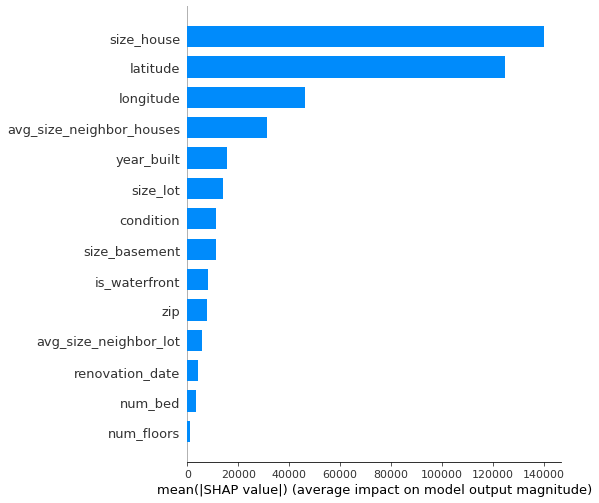

In [52]:
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names = df_features.columns.to_list())